# DAY 44

## 一、预训练的概念

我们之前在训练中发现，准确率最开始随着epoch的增加而增加。随着循环的更新，参数在不断发生更新。

所以参数的初始值对训练结果有很大的影响：
1. 如果最开始的初始值比较好，后续训练轮数就会少很多
2. 很有可能陷入局部最优值，不同的初始值可能导致陷入不同的局部最优值

所以很自然的想到，如果最开始能有比较好的参数，即可能导致未来训练次数少，也可能导致未来训练避免陷入局部最优解的问题。这就引入了一个概念，即预训练模型。

如果别人在某些和我们目标数据类似的大规模数据集上做过训练，我们可以用他的训练参数来初始化我们的模型，这样我们的模型就比较容易收敛。


为了帮助你们理解，这里提出几个自问自答的问题。

1. 那为什么要选择类似任务的数据集预训练的模型参数呢？

因为任务差不多，他提取特征的能力才有用，如果任务相差太大，他的特征提取能力就没那么好。
所以本质预训练就是拿别人已经具备的通用特征提取能力来接着强化能力使之更加适应我们的数据集和任务。

2. 为什么要求预训练模型是在大规模数据集上训练的，小规模不行么？
因为提取的是通用特征，所以如果数据集数据少、尺寸小，就很难支撑复杂任务学习通用的数据特征。比如你是一个物理的博士，让你去做小学数学题，很快就能上手；但是你是一个小学数学速算高手，让你做物理博士的课题，就很困难。所以预训练模型一般就挺强的。

我们把用预训练模型的参数，然后接着在自己数据集上训练来调整该参数的过程叫做微调，这种思想叫做迁移学习。把预训练的过程叫做上游任务，把微调的过程叫做下游任务。

现在再来看下之前一直用的cifar10数据集，他是不是就很明显不适合作为预训练数据集？
1. 规模过小：仅 10 万张图像，且尺寸小（32x32），无法支撑复杂模型学习通用视觉特征；
2. 类别单一：仅 10 类（飞机、汽车等），泛化能力有限；

这里给大家介绍一个常常用来做预训练的数据集，ImageNet，ImageNet 1000 个类别，有 1.2 亿张图像，尺寸 224x224，数据集大小 1.4G，下载地址：http://www.image-net.org/。



## 二、 经典的预训练模型
### 2.1 CNN架构预训练模型


| 模型       | 预训练数据集 | 核心特点                                   | 在CIFAR10上的适配要点                     |  
|------------|--------------|--------------------------------------------|-------------------------------------------|  
| **AlexNet** | ImageNet     | 首次引入ReLU/局部响应归一化，参数量6000万+ | 需修改首层卷积核大小（原11x11→适配32x32） |  
| **VGG16**   | ImageNet     | 纯卷积堆叠，结构统一，参数量1.38亿        | 冻结前10层卷积，仅微调全连接层            |  
| **ResNet18** | ImageNet     | 残差连接解决梯度消失，参数量1100万        | 直接适配32x32输入，需调整池化层步长       |  
| **MobileNetV2** | ImageNet  | 深度可分离卷积，参数量350万+              | 轻量级设计，适合计算资源有限的场景        |  

### 2.2 Transformer类预训练模型  
适用于较大尺图像（如224x224），在CIFAR10上需**上采样图像尺寸**或**调整Patch大小**。   
| 模型       | 预训练数据集 | 核心特点                                   | 在CIFAR10上的适配要点                     |  
|------------|--------------|--------------------------------------------|-------------------------------------------|  
| **ViT-Base** | ImageNet-21K| 纯Transformer架构，参数量8600万           | 图像Resize至224x224，Patch大小设为4x4      |  
| **Swin Transformer** | ImageNet-22K | 分层窗口注意力，参数量8000万+             | 需调整窗口大小适配小图像                  |  
| **DeiT**     | ImageNet     | 结合CNN归纳偏置，参数量2200万             | 轻量级Transformer，适合中小尺寸图像        |  

### 2.3 自监督预训练模型  
无需人工标注，通过 pretext task（如掩码图像重建）学习特征，适合数据稀缺场景。  
| 模型       | 预训练方式       | 典型数据集   | 在CIFAR10上的优势                 |  
|------------|------------------|--------------|-----------------------------------|  
| **MoCo v3** | 对比学习         | ImageNet     | 无需标签即可迁移，适合无标注数据  |  
| **BEiT**    | 掩码图像建模     | ImageNet-22K| 特征语义丰富，微调时收敛更快      |  



## 三、常见的分类预训练模型介绍

### 3.1 预训练模型的发展史


| **模型**       | **年份** | **提出团队**       | **关键创新点**                                                                 | **层数** | **参数量** | **ImageNet Top-5错误率** | **典型应用场景**               | **预训练权重可用性**         |
|----------------|----------|--------------------|--------------------------------------------------------------------------------|----------|------------|--------------------------|------------------------------|------------------------------|
| **LeNet-5**    | 1998     | Yann LeCun等       | 首个CNN架构，卷积层+池化层+全连接层，Sigmoid激活函数                          | 7        | ~60K       | N/A                      | 手写数字识别（MNIST）         | 无（历史模型）               |
| **AlexNet**    | 2012     | Alex Krizhevsky等  | ReLU激活函数、Dropout、数据增强、GPU训练                                        | 8        | 60M        | 15.3%                    | 大规模图像分类               | PyTorch/TensorFlow官方支持   |
| **VGGNet**     | 2014     | Oxford VGG团队     | 统一3×3卷积核、多尺度特征提取、结构简洁                                         | 16/19    | 138M/144M  | 7.3%/7.0%                | 图像分类、目标检测基础骨干网络 | PyTorch/TensorFlow官方支持   |
| **GoogLeNet**  | 2014     | Google             | Inception模块（多分支并行卷积）、1×1卷积降维、全局平均池化                     | 22       | 5M         | 6.7%                     | 大规模图像分类               | PyTorch/TensorFlow官方支持   |
| **ResNet**     | 2015     | 何恺明等           | 残差连接（解决梯度消失）、Batch Normalization                                   | 18/50/152| 11M/25M/60M | 3.57%/3.63%/3.58%        | 图像/视频分类、检测、分割     | PyTorch/TensorFlow官方支持   |
| **DenseNet**   | 2017     | Gao Huang等        | 密集连接（每层与后续所有层相连）、特征复用、参数效率高                         | 121/169  | 8M/14M     | 2.80%                    | 小数据集、医学图像处理        | PyTorch/TensorFlow官方支持   |
| **MobileNet**  | 2017     | Google             | 深度可分离卷积（减少75%计算量）、轻量级设计                                     | 28       | 4.2M       | 7.4%                     | 移动端图像分类/检测           | PyTorch/TensorFlow官方支持   |
| **EfficientNet** | 2019   | Google             | 复合缩放（同时优化深度、宽度、分辨率）、NAS搜索最佳配置                         | B0-B7    | 5.3M-66M   | 2.6% (B7)                | 高精度图像分类（资源受限场景）| PyTorch/TensorFlow官方支持   |

上图的层数，代表该模型不同的版本resnet有resnet18、resnet50、resnet152；efficientnet有efficientnet-b0、efficientnet-b1、efficientnet-b2、efficientnet-b3、efficientnet-b4等


其中ImageNet Top - 5 准确率是图像分类任务里的一种评估指标 ，用于衡量模型在 ImageNet 数据集上的分类性能，模型对图像进行分类预测，输出所有类别（共 1000 类 ）的概率，取概率排名前五的类别，只要这五个类别里包含人工标注的正确类别，就算预测正确。

模型架构演进关键点总结

1. **深度突破**：从LeNet的7层到ResNet152的152层，残差连接解决了深度网络的训练难题。  ----没上过我复试班cv部分的自行去了解下什么叫做残差连接，很重要！
2. **计算效率**：GoogLeNet（Inception）和MobileNet通过结构优化，在保持精度的同时大幅降低参数量。  
3. **特征复用**：DenseNet的密集连接设计使模型能更好地利用浅层特征，适合小数据集。  
4. **自动化设计**：EfficientNet使用神经架构搜索（NAS）自动寻找最优网络配置，开创了AutoML在CNN中的应用。  


预训练模型使用建议

| **任务需求**               | **推荐模型**       | **理由**                                                                 |
|----------------------------|--------------------|--------------------------------------------------------------------------|
| 快速原型开发               | ResNet50/18        | 结构平衡，预训练权重稳定，社区支持完善                                   |
| 移动端部署                 | MobileNetV3        | 参数量小，计算高效，专为移动设备优化                                     |
| 高精度分类（资源充足）     | EfficientNet-B7    | 目前ImageNet准确率领先，适合GPU/TPU环境                                 |
| 小数据集或特征复用需求     | DenseNet           | 密集连接设计减少过拟合，特征复用能力强                                   |
| 多尺度特征提取             | Inception-ResNet   | 结合Inception多分支和ResNet残差连接，适合复杂场景                        |

这些模型的预训练权重均可通过主流框架（如PyTorch的`torchvision.models`、Keras的`applications`模块）直接加载，便于快速迁移到新任务。

总结：CNN 架构发展脉络
1. 早期探索（1990s-2010s）：LeNet 验证 CNN 可行性，但受限于计算和数据。
2. 深度学习复兴（2012-2015）：AlexNet、VGGNet、GoogLeNet 通过加深网络和结构创新突破性能。
3. 超深网络时代（2015 年后）：ResNet 解决退化问题，开启残差连接范式，后续模型围绕效率（MobileNet）、特征复用（DenseNet）、多分支结构（Inception）等方向优化。

### 3.1 预训练模型的训练策略

那么什么模型会被选为预训练模型呢？比如一些调参后表现很好的cnn神经网络（固定的神经元个数+固定的层数等）。

所以调用预训练模型做微调，本质就是 用这些固定的结构+之前训练好的参数 接着训练

所以需要找到预训练的模型结构并且加载模型参数

相较于之前用自己定义的模型有以下几个注意点

1. 需要调用预训练模型和加载权重
2. 需要resize 图片让其可以适配模型
3. 需要修改最后的全连接层以适应数据集

其中，训练过程中，为了不破坏最开始的特征提取器的参数，最开始往往先冻结住特征提取器的参数，然后训练全连接层，大约在5-10个epoch后解冻训练。

主要做特征提取的部分叫做backbone骨干网络；负责融合提取的特征的部分叫做Featue Pyramid Network（FPN）；负责输出的预测部分的叫做Head。

首先复用下之前的代码

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 数据预处理（训练集增强，测试集标准化）
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform
)

# 3. 创建数据加载器（可调整batch_size）
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 训练函数（支持学习率调度器）
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()  # 设置为训练模式
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    all_iter_losses = []
    iter_indices = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # 记录Iteration损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)
            
            # 统计训练指标
            running_loss += iter_loss
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()
            
            # 每100批次打印进度
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} "
                      f"| 单Batch损失: {iter_loss:.4f}")
        
        # 计算 epoch 级指标
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        # 测试阶段
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        
        # 记录历史数据
        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)
        
        # 更新学习率调度器
        if scheduler is not None:
            scheduler.step(epoch_test_loss)
        
        # 打印 epoch 结果
        print(f"Epoch {epoch+1} 完成 | 训练损失: {epoch_train_loss:.4f} "
              f"| 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%")
    
    # 绘制损失和准确率曲线
    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    
    return epoch_test_acc  # 返回最终测试准确率

# 5. 绘制Iteration损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7)
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('训练过程中的Iteration损失变化')
    plt.grid(True)
    plt.show()

# 6. 绘制Epoch级指标曲线
def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('准确率随Epoch变化')
    plt.legend()
    plt.grid(True)
    
    # 损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('损失值随Epoch变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


使用设备: cuda
Files already downloaded and verified


In [14]:
# 导入ResNet模型
from torchvision.models import resnet18

# 定义ResNet18模型（支持预训练权重加载）
def create_resnet18(pretrained=True, num_classes=10):
    # 加载预训练模型（ImageNet权重）
    model = resnet18(pretrained=pretrained)
    
    # 修改最后一层全连接层，适配CIFAR-10的10分类任务
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    # 将模型转移到指定设备（CPU/GPU）
    model = model.to(device)
    return model

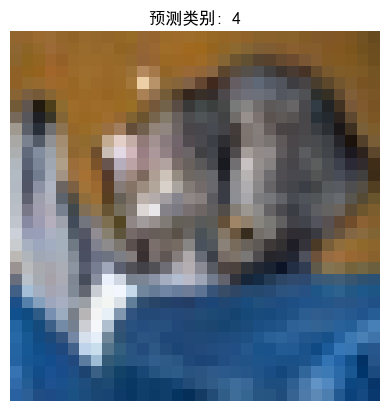

In [15]:
# 创建ResNet18模型（加载ImageNet预训练权重，不进行微调）
model = create_resnet18(pretrained=True, num_classes=10)
model.eval()  # 设置为推理模式

# 测试单张图片（示例）
from torchvision import utils

# 从测试数据集中获取一张图片
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:1].to(device)  # 取第1张图片

# 前向传播
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# 显示图片和预测结果
plt.imshow(utils.make_grid(images.cpu(), normalize=True).permute(1, 2, 0))
plt.title(f"预测类别: {predicted.item()}")
plt.axis('off')
plt.show()

在 **CIFAR-10 数据集** 中，类别标签是固定的 10 个，分别对应：

| 标签（数字） | 类别名称       | 说明                     |
|--------------|----------------|--------------------------|
| 0            | airplane       | 飞机                     |
| 1            | automobile     | 汽车（含轿车、卡车等）   |
| 2            | bird           | 鸟类                     |
| 3            | cat            | 猫                       |
| 4            | deer           | 鹿                       |
| 5            | dog            | 狗                       |
| 6            | frog           | 青蛙                     |
| 7            | horse          | 马                       |
| 8            | ship           | 船                       |
| 9            | truck          | 卡车（重型货车等）       |



使用设备: cuda
Files already downloaded and verified
已冻结模型卷积层参数 (11176512/11181642 参数)
Epoch 1/40 | Batch 100/782 | 单Batch损失: 2.2746
Epoch 1/40 | Batch 200/782 | 单Batch损失: 2.0283
Epoch 1/40 | Batch 300/782 | 单Batch损失: 1.7735
Epoch 1/40 | Batch 400/782 | 单Batch损失: 1.9917
Epoch 1/40 | Batch 500/782 | 单Batch损失: 1.6662
Epoch 1/40 | Batch 600/782 | 单Batch损失: 1.8309
Epoch 1/40 | Batch 700/782 | 单Batch损失: 1.7485
Epoch 1 完成 | 训练损失: 1.9633 | 训练准确率: 29.96% | 测试准确率: 32.28%
Epoch 2/40 | Batch 100/782 | 单Batch损失: 1.9622
Epoch 2/40 | Batch 200/782 | 单Batch损失: 1.9096
Epoch 2/40 | Batch 300/782 | 单Batch损失: 1.9117
Epoch 2/40 | Batch 400/782 | 单Batch损失: 1.6654
Epoch 2/40 | Batch 500/782 | 单Batch损失: 1.8214
Epoch 2/40 | Batch 600/782 | 单Batch损失: 2.0345
Epoch 2/40 | Batch 700/782 | 单Batch损失: 2.1190
Epoch 2 完成 | 训练损失: 1.8675 | 训练准确率: 33.81% | 测试准确率: 32.79%
Epoch 3/40 | Batch 100/782 | 单Batch损失: 1.7294
Epoch 3/40 | Batch 200/782 | 单Batch损失: 1.8884
Epoch 3/40 | Batch 300/782 | 单Batch损失: 2.0095
Epoch 3/40 | Batch 

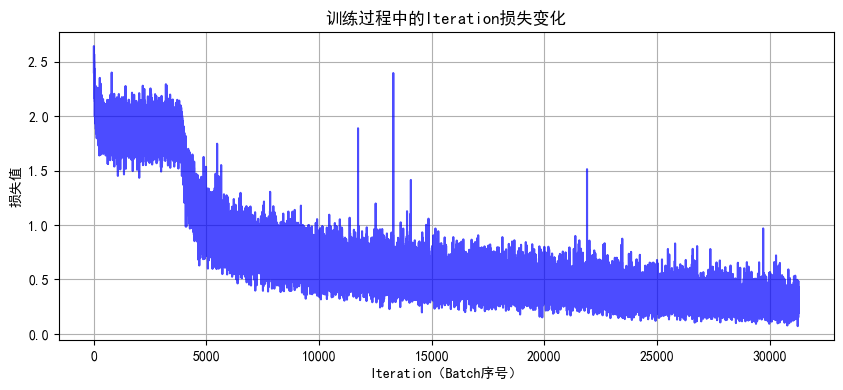

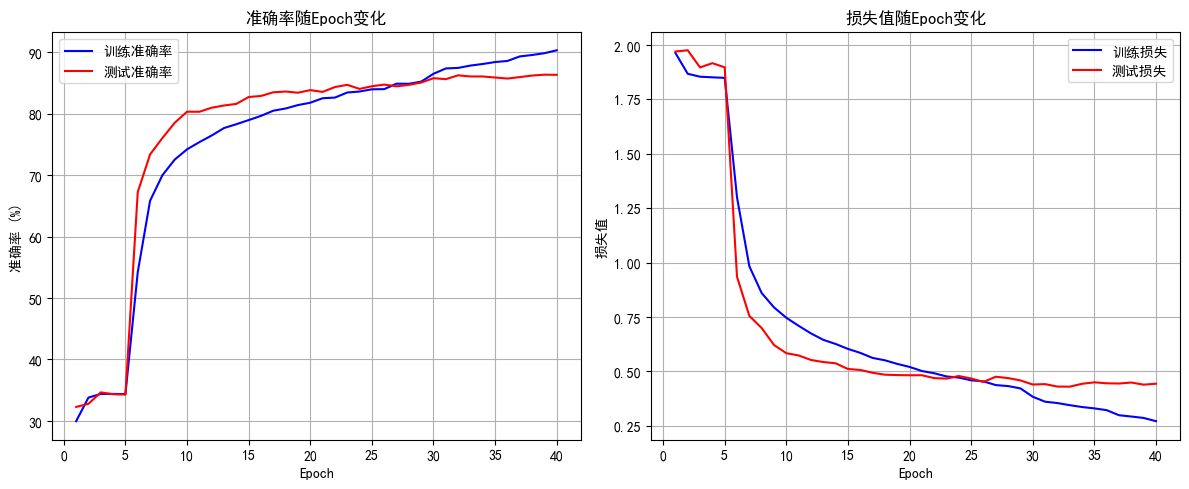

训练完成！最终测试准确率: 86.30%


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 数据预处理（训练集增强，测试集标准化）
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 定义ResNet18模型
def create_resnet18(pretrained=True, num_classes=10):
    model = models.resnet18(pretrained=pretrained)
    
    # 修改最后一层全连接层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model.to(device)

# 5. 冻结/解冻模型层的函数
def freeze_model(model, freeze=True):
    """冻结或解冻模型的卷积层参数"""
    # 冻结/解冻除fc层外的所有参数
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = not freeze
    
    # 打印冻结状态
    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    if freeze:
        print(f"已冻结模型卷积层参数 ({frozen_params}/{total_params} 参数)")
    else:
        print(f"已解冻模型所有参数 ({total_params}/{total_params} 参数可训练)")
    
    return model

# 6. 训练函数（支持阶段式训练）
def train_with_freeze_schedule(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, freeze_epochs=5):
    """
    前freeze_epochs轮冻结卷积层，之后解冻所有层进行训练
    """
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    all_iter_losses = []
    iter_indices = []
    
    # 初始冻结卷积层
    if freeze_epochs > 0:
        model = freeze_model(model, freeze=True)
    
    for epoch in range(epochs):
        # 解冻控制：在指定轮次后解冻所有层
        if epoch == freeze_epochs:
            model = freeze_model(model, freeze=False)
            # 解冻后调整优化器（可选）
            optimizer.param_groups[0]['lr'] = 1e-4  # 降低学习率防止过拟合
        
        model.train()  # 设置为训练模式
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # 记录Iteration损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)
            
            # 统计训练指标
            running_loss += iter_loss
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()
            
            # 每100批次打印进度
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} "
                      f"| 单Batch损失: {iter_loss:.4f}")
        
        # 计算 epoch 级指标
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        # 测试阶段
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        
        # 记录历史数据
        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)
        
        # 更新学习率调度器
        if scheduler is not None:
            scheduler.step(epoch_test_loss)
        
        # 打印 epoch 结果
        print(f"Epoch {epoch+1} 完成 | 训练损失: {epoch_train_loss:.4f} "
              f"| 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%")
    
    # 绘制损失和准确率曲线
    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    
    return epoch_test_acc  # 返回最终测试准确率

# 7. 绘制Iteration损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7)
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('训练过程中的Iteration损失变化')
    plt.grid(True)
    plt.show()

# 8. 绘制Epoch级指标曲线
def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('准确率随Epoch变化')
    plt.legend()
    plt.grid(True)
    
    # 损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('损失值随Epoch变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 主函数：训练模型
def main():
    # 参数设置
    epochs = 40  # 总训练轮次
    freeze_epochs = 5  # 冻结卷积层的轮次
    learning_rate = 1e-3  # 初始学习率
    weight_decay = 1e-4  # 权重衰减
    
    # 创建ResNet18模型（加载预训练权重）
    model = create_resnet18(pretrained=True, num_classes=10)
    
    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # 定义学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # 开始训练（前5轮冻结卷积层，之后解冻）
    final_accuracy = train_with_freeze_schedule(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=epochs,
        freeze_epochs=freeze_epochs
    )
    
    print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")
    
    # # 保存模型
    # torch.save(model.state_dict(), 'resnet18_cifar10_finetuned.pth')
    # print("模型已保存至: resnet18_cifar10_finetuned.pth")

if __name__ == "__main__":
    main()

几个明显的现象
1. 解冻后几个epoch即可达到之前cnn训练20轮的效果，这是预训练的优势
2. 由于训练集用了 RandomCrop（随机裁剪）、RandomHorizontalFlip（随机水平翻转）、ColorJitter（颜色抖动）等数据增强操作，这会让训练时模型看到的图片有更多 “干扰” 或变形。比如一张汽车图片，训练时可能被裁剪成只显示局部、颜色也有变化，模型学习难度更高；而测试集是标准的、没增强的图片，模型预测相对轻松，就可能出现训练集准确率暂时低于测试集的情况，尤其在训练前期增强对模型影响更明显。随着训练推进，模型适应增强后会缓解。
3. 最后收敛后的效果超过非预训练模型的80%,大幅提升